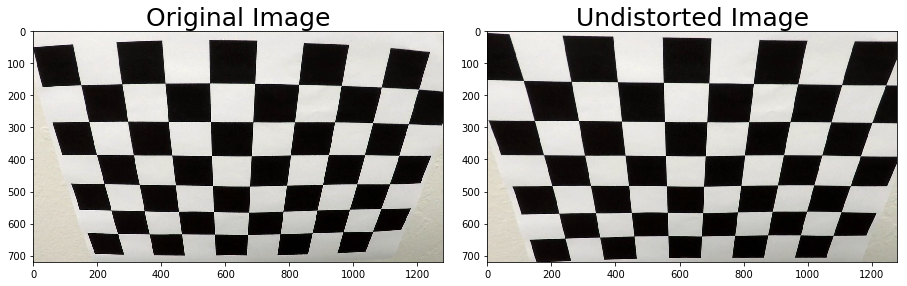

In [1]:
# Run one time for either an individual image or the pipeline

#################################
# Calibrate the camera
##############################

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

%matplotlib inline

def calibrate_camera():
    # Returns:
    #  mtx: camera matrix
    #  dist: distortion coefficients
    
    # Read in the images
    images = glob.glob('camera_cal\calibration*.jpg')

    #test_img = mpimg.imread('calibration2.jpg')
    #plt.imshow(test_img)
    #plt.show()

    # Points used to calibrate the camera
    objpoints = [] # 3D points in real world space
    imgpoints = [] # 2D points in image plane

    nx = 9 # Number of corners in x direction
    ny = 6 # Number of corners in y direction

    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    # Cycle through each image gathering points for camera calibration
    for fname in images:
        img = mpimg.imread(fname) # read the image into an numpy array

        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If corners are found
        if ret == True:
            # add image points and object points
            imgpoints.append(corners)
            objpoints.append(objp)

            # Draw and display the corners
            #img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    # show undistorted images
    fname = images[10] #select an original image to display
    original_img = mpimg.imread(fname) # read the original image into an numpy array
    undistorted_img = cv2.undistort(original_img, mtx, dist, None, mtx)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    f.tight_layout()
    ax1.imshow(original_img)
    ax1.set_title('Original Image', fontsize=25)
    ax2.imshow(undistorted_img)
    ax2.set_title('Undistorted Image', fontsize=25)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()

    return mtx, dist

#############################
# Calibrates the camera
g_mtx, g_dist = calibrate_camera()

In [2]:
# Run once

## Utility method

# Display 2 color images side-by-side
def display_2_images(image1, image1title, image2, image2title):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    f.tight_layout()
    ax1.imshow(image1)
    ax1.set_title(image1title, fontsize=25)
    ax2.imshow(image2)
    ax2.set_title(image2title, fontsize=25)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()
    
def display_2_g_images(image1, image1title, image2, image2title):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    f.tight_layout()
    ax1.imshow(image1, cmap='gray')
    ax1.set_title(image1title, fontsize=25)
    ax2.imshow(image2, cmap='gray')
    ax2.set_title(image2title, fontsize=25)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()


In [3]:
# Run once
##############################################################
#Apply distortion correction to a road image
############################################

def correct_distortion(original, mtx, dist):
    ## Applies distortion correction to a road image
    # params
    #     original: numpy array of the unchanged image
    # returns:
    #     undistorted: the original image with distortion removed
    
    undistorted = cv2.undistort(original, mtx, dist, None, mtx)

    return undistorted


In [4]:
##############################################################################################
# Use color transforms, gradients, etc., to create a thresholded binary image.
###################################################################333

#########################################################
# Define gradient and color thresholding methods

# Define a function that takes an image, gradient orientation,
#   and threshold min / max values.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh_min=0, thresh_max=255): 
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:  # assume 'y'
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 6) Return this mask as the binary_output image
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8-bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # Return the binary image
    return binary_output

# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_S_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls_image[:,:,2]
    # 2) Apply a threshold to the S channel
    binary_output = np.zeros_like(S)
    binary_output[(S > thresh[0]) & (S <= thresh[1])] = 1
    return binary_output

# Define a function that thresholds the L-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_L_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    L = hls_image[:,:,1]
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(L)
    binary_output[(L > thresh[0]) & (L <= thresh[1])] = 1
    return binary_output

########################################
# Apply thresholding
##########################

def apply_thresholding(undistorted_img, single=False):
    #  Use color transforms and gradients to create a thresholded binary image.
    
    # Input:
    #    kernel_size: Must be odd. Used in the Sobel methods. Use a larger odd number to smooth gradient measurements more.
    # Returns:
    #    combined_binary: the resulting color image of applying all the transforms to an undistorted image
    #    grad_x_binary
    #    grad_y_binary
    #    mag_binary
    #    dir_binary
    #    hls_L_binary
    #    hls_S_binary
    
    kernel_size=15
    
    # Apply the thresholding methods
    grad_x_binary = abs_sobel_thresh(undistorted_img, orient='x', thresh_min=20, thresh_max=100)
    grad_y_binary = abs_sobel_thresh(undistorted_img, orient='y', thresh_min=20, thresh_max=100)
    mag_binary = mag_thresh(undistorted_img, sobel_kernel=kernel_size, mag_thresh=(30, 200))
    dir_binary = dir_threshold(undistorted_img, sobel_kernel=kernel_size, thresh=(0.7, 1.3))
    hls_L_binary = hls_L_select(undistorted_img, thresh=(90, 175))
    hls_S_binary = hls_S_select(undistorted_img, thresh=(90, 250))

    combined_binary = np.zeros_like(dir_binary)
    combined_binary[((grad_x_binary == 1) & (grad_y_binary == 1))
                    | ((mag_binary == 1) & (dir_binary == 1)) 
                    | ((hls_S_binary == 1) )] = 1
    
    if single == True:
        # Display thresholding images from a single image

        # Plot the Original and Combined images
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(undistorted_img)
        ax1.set_title('Original Image', fontsize=50)
        ax2.imshow(combined_binary, cmap='gray')
        ax2.set_title('Combined', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        plt.show()

        # Plot the HLS L & S images
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(hls_L_binary)
        ax1.set_title('Thresholded L', fontsize=50)
        ax2.imshow(hls_S_binary, cmap='gray')
        ax2.set_title('Thresholded S', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        plt.show()

        # PLot the gradient x and y images
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(grad_x_binary, cmap='gray')
        ax1.set_title('Thresholded Gradient x', fontsize=50)
        ax2.imshow(grad_y_binary, cmap='gray')
        ax2.set_title('Thresholded Gradient y', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        plt.show()

        # Plot the magnitude and direction gradient images
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(mag_binary, cmap='gray')
        ax1.set_title('Thresholded Magnitude', fontsize=50)
        ax2.imshow(dir_binary, cmap='gray')
        ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        plt.show()

    return combined_binary #TODO: add these if necessary, grad_x_binary, grad_y_binary, mag_binary, dir_binary, hls_L_binary, hls_S_binary


In [5]:
#####################################################################################
# Apply a perspective transform to rectify binary image ("birds-eye view").
##############################################################

def warp(img):
    img_size = (img.shape[1], img.shape[0])
    src = np.float32(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])
    # Compute the perspective transform M
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Create the warped image -- uses linear interpolation
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    ## Only used to generate data for the report
    # Add line to original image
    #cv2.polylines(img, [np.int32(src)], 1, (255,0,0), 4)
    #cv2.polylines(warped, [np.int32(dst)], 1, (255,0,0), 4)
    #print("src: ")
    #print(src)
    #print("dst: ")
    #print(dst)
    # Run for a single image calculation
    
    return warped, Minv


In [29]:
#######################################################################
# Detect lane pixels and fit to find the lane boundary.
###############################################

def detect_lane_pixels_and_find_lane_boundary(bin_warped, single=False):
    # Take a histogram of the bottom half of the warped binary image
    histogram = np.sum(bin_warped[int(bin_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result

    # Original line:
    # out_img = np.dstack((gray_warped, gray_warped, gray_warped))*255
    out_img = 255*np.dstack((bin_warped, bin_warped, bin_warped)).astype('uint8')

    #######################################################################################33
    # DEBUG:
    #f, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10))

    #ax1.set_title("bin_warped")
    #img1 = bin_warped
    #ax1.imshow(img1)
    #ax2.set_title("bin_warped")
    #ax2.imshow(bin_warped)
    #plt.show()

    ############################################################

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(bin_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = bin_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = bin_warped.shape[0] - (window+1)*window_height
        win_y_high = bin_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)


    # Generate x and y values for plotting
    ploty = np.linspace(0, bin_warped.shape[0]-1, bin_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    ############################################
    # Visualize the sliding window
    #########################
    if single:
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        ## The following saves the image. Used to demonstrate that a 2-sized line writes boxes to the 
        #    image even if it doesn't display to the screen correctly.
        #cv2.imwrite('boxed_image3.jpg', out_img)
    
    return out_img, ploty, left_fit, right_fit, left_fitx, right_fitx

In [38]:
##################################################################################
# Determine the curvature of the lane and vehicle position with respect to center
####################################################3

def determine_curvature_and_position(ploty, left_fit, right_fit, left_fitx, right_fitx, single=False):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    if single:
        print(left_curverad, right_curverad)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    if single:
        print(left_curverad, 'm', right_curverad, 'm')
    
    return left_curverad, right_curverad


In [31]:
##########################################################################################
# Warp the detected lane boundaries back onto the original image.
#################################################################

def warp_lanes_onto_original_image(binary_warped, undistorted_img, Minv, left_fitx, right_fitx, ploty, left_curverad, right_curverad, single=False):
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (color_warp.shape[1], color_warp.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.3, 0)

    # Calculate the average radius of curvature
    curverad = (left_curverad + right_curverad)/2

    cv2.putText(result, 'Radius of Curve {:.0f} meters'.format(curverad), (100,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),2)

    ## Save the image to disk for the writeup.
    #cv2.imwrite('output_images\example_output2.jpg', result)

    if single:
        plt.imshow(result)
    
    return result

In [32]:
################################################################
# image processing pipeline
###############################
def process_image(i_original_color, single=False):
    # Input:
    #   original_color: the original color image to be processed
    #   single: True if procesing a single image.  This will display intermediate, debug images.
    #           False if called from the video creation routine.  Will not display intermediate images.
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # Returns the final output (image where lines are drawn on lanes)
    
    i_undistorted_color = correct_distortion(i_original_color, g_mtx, g_dist)
    if single:  # if processing a single image, display the resulting images
        display_2_images(i_original_color, 'Original image', i_undistorted_color, 'Undistorted Image')
    
    if single:  # if processing a single image, tell method to display the resulting images
        i_combined_binary = apply_thresholding(i_undistorted_color, True)
    else:       # if processing a video, tell method not to display the resulting images
        i_combined_binary = apply_thresholding(i_undistorted_color, False)
    
    i_binary_warped, i_Minv = warp(i_combined_binary)
    
    if single:
        i_lanes_img, g_ploty, g_left_fit, g_right_fit, g_left_fitx, g_right_fitx = detect_lane_pixels_and_find_lane_boundary(i_binary_warped, True)
    else:
        i_lanes_img, g_ploty, g_left_fit, g_right_fit, g_left_fitx, g_right_fitx = detect_lane_pixels_and_find_lane_boundary(i_binary_warped, False)
    
    i_left_curverad, i_right_curverad = determine_curvature_and_position(g_ploty, g_left_fit, g_right_fit, g_left_fitx, g_right_fitx)
    
    if single:
        final_image = warp_lanes_onto_original_image(i_binary_warped, i_undistorted_color, i_Minv, g_left_fitx, g_right_fitx, g_ploty, i_left_curverad, i_right_curverad, True)
    else:
        final_image = warp_lanes_onto_original_image(i_binary_warped, i_undistorted_color, i_Minv, g_left_fitx, g_right_fitx, g_ploty, i_left_curverad, i_right_curverad, False)
    
    return final_image



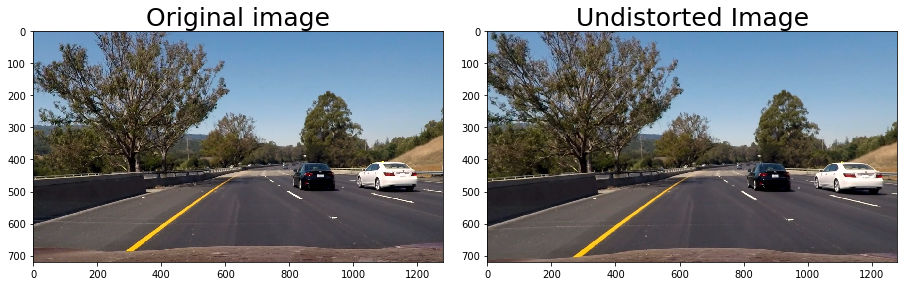

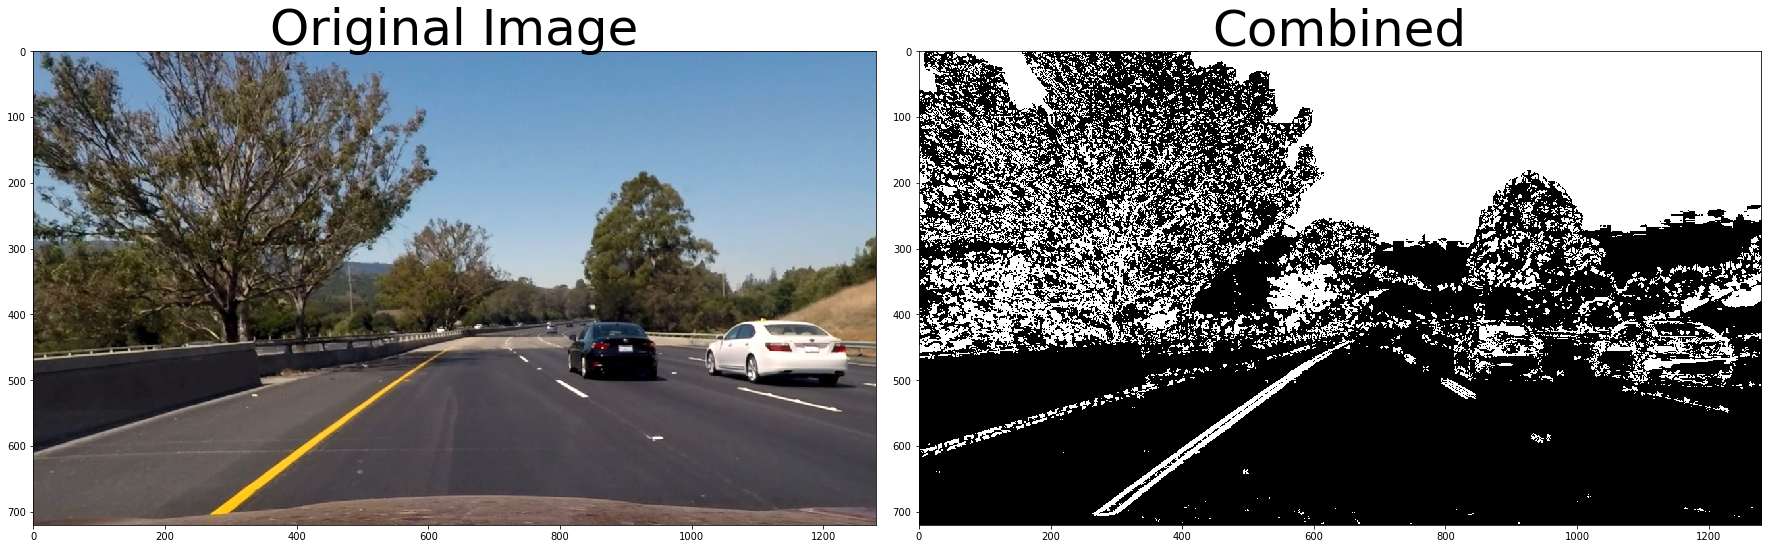

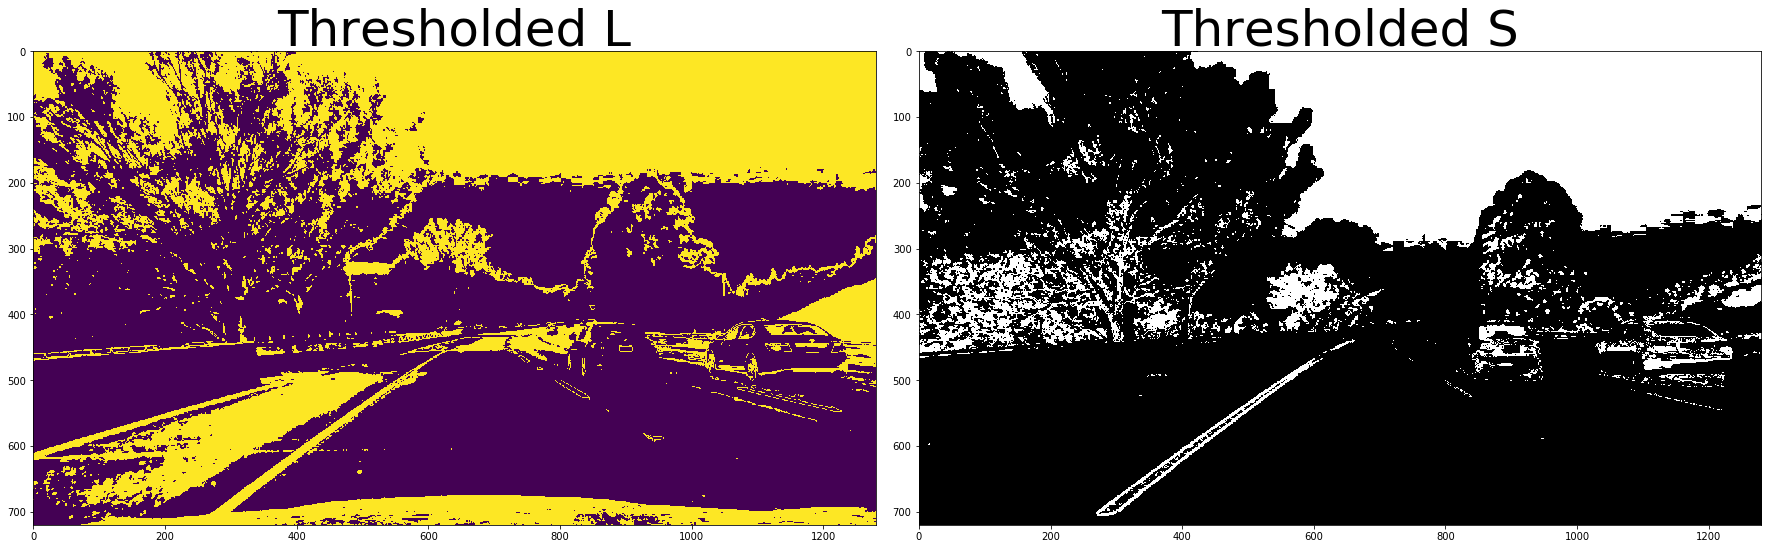

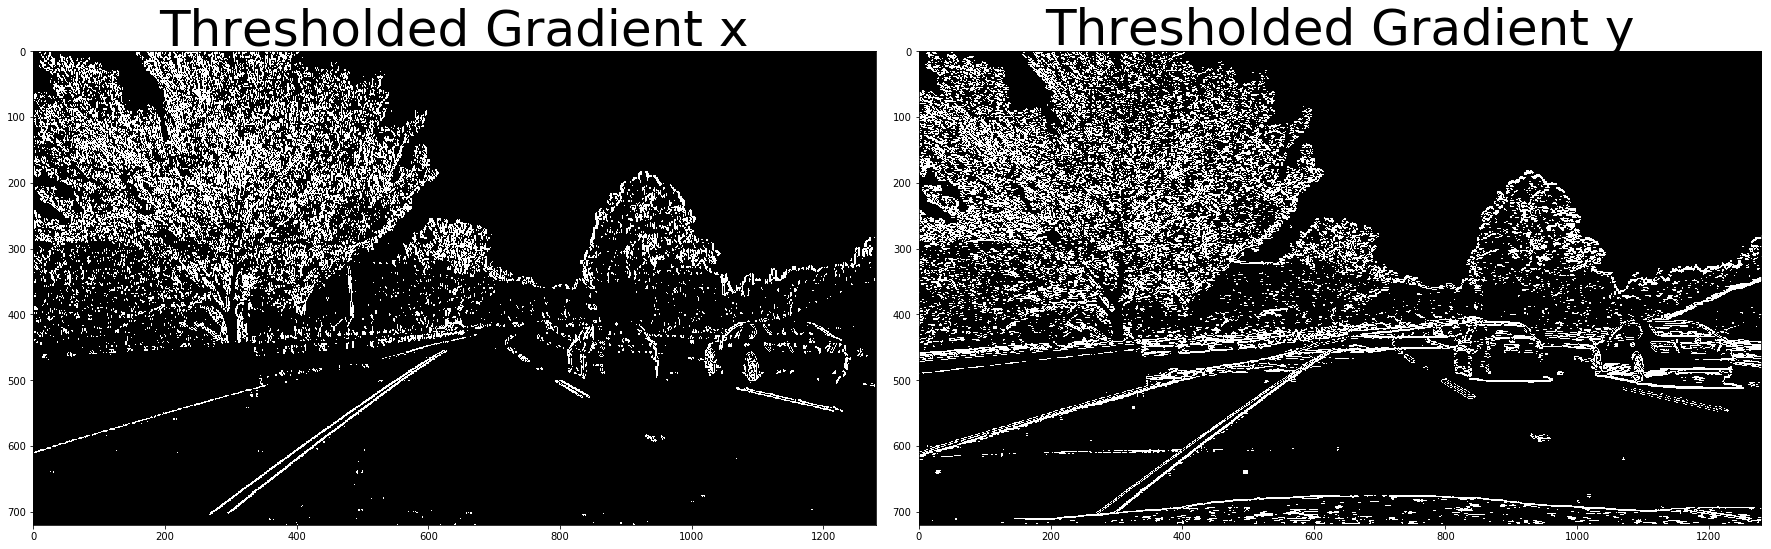

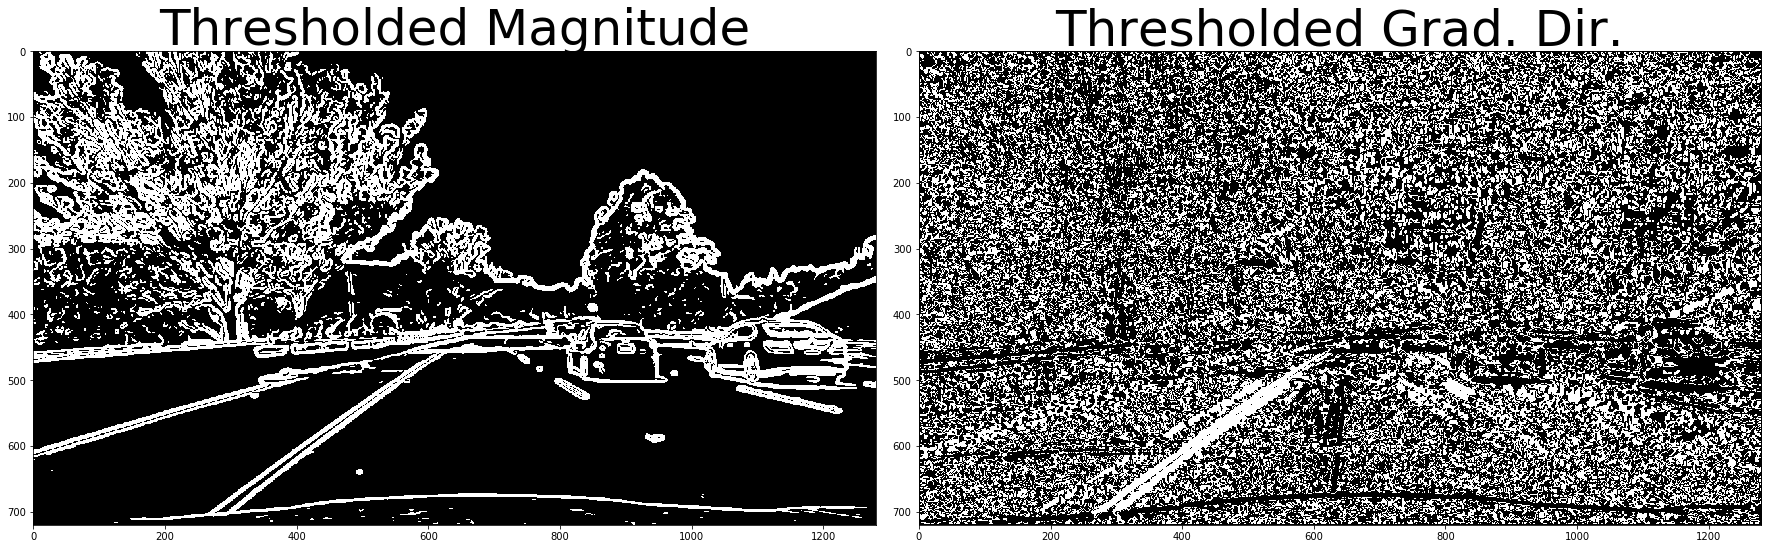

2998.29791728 1287.64292327
975.28324176 m 422.738937985 m


array([[[115, 154, 193],
        [114, 153, 192],
        [114, 153, 192],
        ..., 
        [ 97, 150, 192],
        [ 97, 150, 192],
        [ 98, 150, 192]],

       [[115, 154, 194],
        [115, 154, 194],
        [115, 154, 193],
        ..., 
        [ 97, 150, 192],
        [ 97, 150, 192],
        [ 97, 150, 192]],

       [[115, 154, 195],
        [115, 154, 195],
        [115, 154, 195],
        ..., 
        [ 97, 150, 192],
        [ 97, 150, 192],
        [ 97, 150, 192]],

       ..., 
       [[ 91,  66,  62],
        [ 90,  66,  62],
        [ 90,  65,  61],
        ..., 
        [116,  89,  80],
        [115,  88,  79],
        [116,  89,  80]],

       [[ 95,  69,  66],
        [ 95,  69,  66],
        [ 96,  70,  67],
        ..., 
        [122,  95,  86],
        [120,  93,  84],
        [119,  92,  83]],

       [[ 97,  69,  68],
        [ 97,  69,  68],
        [ 98,  70,  69],
        ..., 
        [125,  99,  89],
        [126,  99,  90],
        [125,  98,

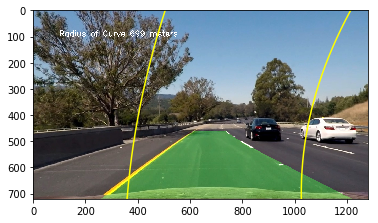

In [33]:
##################################################################
# Create a single image
###############################################
# Run for a single image calculation

# apply distortion correction for a single image
g_fname = 'test_images\\test6.jpg' # select an image to process
g_original_img = mpimg.imread(g_fname) # read the original image into an numpy array
process_image(g_original_img, True)


In [37]:
#################################################################
# Create a video
########################################

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'challenge_video_result.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


1251.09843425 2983.70798217
[MoviePy] >>>> Building video challenge_video_result.mp4
[MoviePy] Writing video challenge_video_result.mp4


  0%|                                                  | 0/485 [00:00<?, ?it/s]

1251.09843425 2983.70798217


  0%|                                          | 1/485 [00:00<04:22,  1.85it/s]

1454.22230831 2650.93409214


  0%|▏                                         | 2/485 [00:01<04:27,  1.81it/s]

1497.21613864 1792.66242084


  1%|▎                                         | 3/485 [00:01<04:33,  1.76it/s]

1408.90519411 10056.026381


  1%|▎                                         | 4/485 [00:02<04:29,  1.79it/s]

1386.86664601 23818.768846


  1%|▍                                         | 5/485 [00:03<05:22,  1.49it/s]

2369.66577242 29305.4520806


  1%|▌                                         | 6/485 [00:04<05:43,  1.39it/s]

1750.1343459 9401.18612986


  1%|▌                                         | 7/485 [00:04<04:58,  1.60it/s]

1637.93549051 19101.9223063


  2%|▋                                         | 8/485 [00:04<04:21,  1.83it/s]

2406.17657243 50417.0298906


  2%|▊                                         | 9/485 [00:05<03:53,  2.04it/s]

601.393508843 30547.5807378


  2%|▊                                        | 10/485 [00:05<03:41,  2.15it/s]

1256.60928676 12149.0225041


  2%|▉                                        | 11/485 [00:06<04:35,  1.72it/s]

1076.90150097 7253.08018315


  2%|█                                        | 12/485 [00:07<05:00,  1.57it/s]

1251.6744706 54936.4676444


  3%|█                                        | 13/485 [00:07<04:23,  1.79it/s]

1996.90172452 21557.1694042


  3%|█▏                                       | 14/485 [00:07<03:57,  1.99it/s]

2508.2935526 8024.85007103


  3%|█▎                                       | 15/485 [00:08<03:41,  2.12it/s]

1140.54248475 20788.5739573


  3%|█▎                                       | 16/485 [00:08<03:28,  2.25it/s]

1006.7673656 25974.0995535


  4%|█▍                                       | 17/485 [00:09<04:24,  1.77it/s]

951.643232382 2877.17645528


  4%|█▌                                       | 18/485 [00:10<04:45,  1.63it/s]

944.960939082 10730.3467412


  4%|█▌                                       | 19/485 [00:10<04:20,  1.79it/s]

1038.73126808 14981.433586


  4%|█▋                                       | 20/485 [00:11<04:48,  1.61it/s]

996.954873715 4821.04092412


  4%|█▊                                       | 21/485 [00:11<04:17,  1.80it/s]

1727.22672398 6091.40780832


  5%|█▊                                       | 22/485 [00:12<04:45,  1.62it/s]

1021.49314741 17930.2525668


  5%|█▉                                       | 23/485 [00:13<05:07,  1.50it/s]

1350.99525287 6465450.27727


  5%|██                                       | 24/485 [00:14<05:17,  1.45it/s]

4298.9865659 2173.74280131


  5%|██                                       | 25/485 [00:14<05:13,  1.47it/s]

2642.21914268 5225.26966798


  5%|██▏                                      | 26/485 [00:15<05:32,  1.38it/s]

3355.76071545 196340.470694


  6%|██▎                                      | 27/485 [00:16<05:42,  1.34it/s]

2387.64365381 161530.840674


  6%|██▎                                      | 28/485 [00:17<05:35,  1.36it/s]

2081.21480232 9326.4039795


  6%|██▍                                      | 29/485 [00:17<05:01,  1.51it/s]

2164.78111 1731.7988645


  6%|██▌                                      | 30/485 [00:18<05:25,  1.40it/s]

2530.8086118 19615.3595319


  6%|██▌                                      | 31/485 [00:19<05:33,  1.36it/s]

3800.03878969 45609.6627636


  7%|██▋                                      | 32/485 [00:20<05:43,  1.32it/s]

2536.03436918 12680.6659


  7%|██▊                                      | 33/485 [00:20<05:57,  1.27it/s]

1093.25109364 2261.3096418


  7%|██▊                                      | 34/485 [00:21<06:08,  1.22it/s]

780.479235646 3495.07638361


  7%|██▉                                      | 35/485 [00:22<05:29,  1.37it/s]

689.574472383 51490.0555724


  7%|███                                      | 36/485 [00:23<05:30,  1.36it/s]

652.98353146 5041.60784574


  8%|███▏                                     | 37/485 [00:23<05:27,  1.37it/s]

614.02019728 71165.6372178


  8%|███▏                                     | 38/485 [00:24<05:25,  1.37it/s]

621.266666057 810492.440012


  8%|███▎                                     | 39/485 [00:24<04:43,  1.57it/s]

629.513429193 2559.84053304


  8%|███▍                                     | 40/485 [00:25<04:10,  1.78it/s]

642.591483951 2224.77806477


  8%|███▍                                     | 41/485 [00:25<04:11,  1.76it/s]

639.513610149 1644.11770803


  9%|███▌                                     | 42/485 [00:26<04:00,  1.84it/s]

611.644984041 5516.02390085


  9%|███▋                                     | 43/485 [00:26<03:58,  1.85it/s]

596.382946624 1347.66496712


  9%|███▋                                     | 44/485 [00:27<03:55,  1.87it/s]

547.775093269 1230.97196994


  9%|███▊                                     | 45/485 [00:27<03:49,  1.92it/s]

546.609706329 1022.90178336


  9%|███▉                                     | 46/485 [00:28<03:34,  2.05it/s]

542.914404855 1244.94585677


 10%|███▉                                     | 47/485 [00:28<03:18,  2.21it/s]

536.125564999 1052.57003751


 10%|████                                     | 48/485 [00:29<03:10,  2.30it/s]

508.63916366 986.713851021


 10%|████▏                                    | 49/485 [00:29<03:00,  2.42it/s]

500.045036049 1020.05445529


 10%|████▏                                    | 50/485 [00:29<02:54,  2.49it/s]

482.588284043 3195.77798484


 11%|████▎                                    | 51/485 [00:30<02:50,  2.54it/s]

467.56102364 3338.62429679


 11%|████▍                                    | 52/485 [00:30<02:51,  2.53it/s]

458.001405004 2591.20544762


 11%|████▍                                    | 53/485 [00:31<02:51,  2.51it/s]

469.876709344 892.337163651


 11%|████▌                                    | 54/485 [00:31<02:50,  2.53it/s]

478.450030777 2444.17622635


 11%|████▋                                    | 55/485 [00:31<02:50,  2.52it/s]

481.640009764 1591.38816431


 12%|████▋                                    | 56/485 [00:32<02:51,  2.51it/s]

471.781231539 1287.29063535


 12%|████▊                                    | 57/485 [00:32<02:50,  2.51it/s]

474.977725482 821.66860794


 12%|████▉                                    | 58/485 [00:33<02:51,  2.49it/s]

480.246983279 794.542644319


 12%|████▉                                    | 59/485 [00:33<02:47,  2.55it/s]

496.452250221 881.336458638


 12%|█████                                    | 60/485 [00:33<02:46,  2.55it/s]

523.038329679 991.936912149


 13%|█████▏                                   | 61/485 [00:34<02:51,  2.48it/s]

542.068371678 1047.05453042


 13%|█████▏                                   | 62/485 [00:34<02:48,  2.51it/s]

572.679642839 1096.11425672


 13%|█████▎                                   | 63/485 [00:35<02:45,  2.55it/s]

541.921714671 1396.86654764


 13%|█████▍                                   | 64/485 [00:35<02:44,  2.56it/s]

609.194375578 1012.37742934


 13%|█████▍                                   | 65/485 [00:35<02:42,  2.58it/s]

595.441577884 902.666763195


 14%|█████▌                                   | 66/485 [00:36<02:43,  2.56it/s]

594.783372494 856.744717239


 14%|█████▋                                   | 67/485 [00:36<02:47,  2.49it/s]

630.623679293 3323.41679728


 14%|█████▋                                   | 68/485 [00:36<02:45,  2.51it/s]

564.050715788 3266.87748288


 14%|█████▊                                   | 69/485 [00:37<02:46,  2.50it/s]

600.897385823 1422.36478388


 14%|█████▉                                   | 70/485 [00:37<02:53,  2.39it/s]

699.602024185 2150.99581574


 15%|██████                                   | 71/485 [00:38<02:51,  2.41it/s]

809.294682649 2003.65602616


 15%|██████                                   | 72/485 [00:38<02:48,  2.46it/s]

839.333443692 1988.60490767


 15%|██████▏                                  | 73/485 [00:39<02:50,  2.42it/s]

842.60825786 1757.4887667


 15%|██████▎                                  | 74/485 [00:39<02:46,  2.46it/s]

832.045212923 1644.55613255


 15%|██████▎                                  | 75/485 [00:39<02:43,  2.51it/s]

807.597013221 1186.4076678


 16%|██████▍                                  | 76/485 [00:40<02:41,  2.54it/s]

828.520652144 1168.90663603


 16%|██████▌                                  | 77/485 [00:40<02:40,  2.55it/s]

878.585431221 1108.35668283


 16%|██████▌                                  | 78/485 [00:40<02:36,  2.60it/s]

986.208492636 1346.86738616


 16%|██████▋                                  | 79/485 [00:41<02:34,  2.63it/s]

1077.05293477 1634.95622135


 16%|██████▊                                  | 80/485 [00:41<02:33,  2.63it/s]

948.33803131 3372.28384441


 17%|██████▊                                  | 81/485 [00:42<02:34,  2.61it/s]

1109.79965393 2472.11012218


 17%|██████▉                                  | 82/485 [00:42<02:36,  2.58it/s]

1344.99520155 3625.38563625


 17%|███████                                  | 83/485 [00:42<02:35,  2.58it/s]

1465.71360172 2520.54545683


 17%|███████                                  | 84/485 [00:43<02:34,  2.60it/s]

1315.45012078 20778.3289942


 18%|███████▏                                 | 85/485 [00:43<02:32,  2.63it/s]

1363.11592566 7141.85316843


 18%|███████▎                                 | 86/485 [00:44<02:32,  2.61it/s]

935.32847073 1396.09960335


 18%|███████▎                                 | 87/485 [00:44<02:31,  2.62it/s]

1160.9361177 1910.12539085


 18%|███████▍                                 | 88/485 [00:44<02:29,  2.66it/s]

986.380524644 2051.27910417


 18%|███████▌                                 | 89/485 [00:45<02:29,  2.65it/s]

1025.30842676 1159.94421136


 19%|███████▌                                 | 90/485 [00:45<02:29,  2.63it/s]

943.871404462 1473.63610167


 19%|███████▋                                 | 91/485 [00:45<02:27,  2.67it/s]

902.408954504 1157.62169429


 19%|███████▊                                 | 92/485 [00:46<02:27,  2.66it/s]

1049.35205249 1030.52965098


 19%|███████▊                                 | 93/485 [00:46<02:26,  2.68it/s]

990.906960809 926.657431159


 19%|███████▉                                 | 94/485 [00:47<02:25,  2.68it/s]

772.063084599 893.757684863


 20%|████████                                 | 95/485 [00:47<02:24,  2.69it/s]

706.85963437 897.609011629


 20%|████████                                 | 96/485 [00:47<02:32,  2.55it/s]

572.852484914 806.562648488


 20%|████████▏                                | 97/485 [00:48<02:28,  2.62it/s]

535.552527817 815.797204732


 20%|████████▎                                | 98/485 [00:48<02:26,  2.64it/s]

487.80378504 3617.44070848


 20%|████████▎                                | 99/485 [00:48<02:22,  2.70it/s]

521.825665197 971.575339579


 21%|████████▏                               | 100/485 [00:49<02:23,  2.69it/s]

484.51169308 956.744960755


 21%|████████▎                               | 101/485 [00:49<02:21,  2.72it/s]

506.1737537 1040.30072863


 21%|████████▍                               | 102/485 [00:50<02:20,  2.72it/s]

559.848535634 981.968010362


 21%|████████▍                               | 103/485 [00:50<02:20,  2.72it/s]

651.169341782 964.748546638


 21%|████████▌                               | 104/485 [00:50<02:20,  2.71it/s]

541.320422039 733.614643434


 22%|████████▋                               | 105/485 [00:51<02:19,  2.72it/s]

544.27952325 777.687088068


 22%|████████▋                               | 106/485 [00:51<02:21,  2.68it/s]

544.109267699 726.256841666


 22%|████████▊                               | 107/485 [00:51<02:19,  2.71it/s]

458.655459654 787.101462344


 22%|████████▉                               | 108/485 [00:52<02:20,  2.69it/s]

445.42531479 926.862504818


 22%|████████▉                               | 109/485 [00:52<02:22,  2.65it/s]

415.506446613 1243.64195313


 23%|█████████                               | 110/485 [00:53<02:23,  2.62it/s]

433.423883968 1209.50411099


 23%|█████████▏                              | 111/485 [00:53<02:22,  2.63it/s]

396.841540342 1258.51587756


 23%|█████████▏                              | 112/485 [00:53<02:20,  2.65it/s]

387.874587887 1314.40951617


 23%|█████████▎                              | 113/485 [00:54<02:19,  2.67it/s]

370.044876353 1245.16273504


 24%|█████████▍                              | 114/485 [00:54<02:18,  2.68it/s]

330.526213472 1254.69425901


 24%|█████████▍                              | 115/485 [00:54<02:15,  2.72it/s]

330.433194707 1251.05963041


 24%|█████████▌                              | 116/485 [00:55<02:16,  2.70it/s]

312.151036153 1289.68771566


 24%|█████████▋                              | 117/485 [00:55<02:14,  2.73it/s]

323.7696884 1680.07548764


 24%|█████████▋                              | 118/485 [00:55<02:15,  2.72it/s]

330.3977164 2471.09289643


 25%|█████████▊                              | 119/485 [00:56<02:13,  2.74it/s]

364.449603134 1235.64566064


 25%|█████████▉                              | 120/485 [00:56<02:12,  2.75it/s]

241.313309385 1215.17108611


 25%|█████████▉                              | 121/485 [00:57<02:11,  2.77it/s]

214.147628947 1176.13072379


 25%|██████████                              | 122/485 [00:57<02:11,  2.76it/s]

13388.6919058 1144.37479361


 25%|██████████▏                             | 123/485 [00:57<02:13,  2.72it/s]

4610.94045268 1131.82200161


 26%|██████████▏                             | 124/485 [00:58<02:12,  2.73it/s]

24226.5772882 1061.8466011


 26%|██████████▎                             | 125/485 [00:58<02:38,  2.27it/s]

2644.43408198 1063.66264751


 26%|██████████▍                             | 126/485 [00:59<02:49,  2.12it/s]

6391.01989443 1044.30710432


 26%|██████████▍                             | 127/485 [00:59<02:42,  2.20it/s]

468.352868394 996.026598917


 26%|██████████▌                             | 128/485 [01:00<02:31,  2.35it/s]

433.302269158 258517.803678


 27%|██████████▋                             | 129/485 [01:00<02:26,  2.43it/s]

370.201399588 2989.96947233


 27%|██████████▋                             | 130/485 [01:00<02:19,  2.54it/s]

469.476965431 1331.17512452


 27%|██████████▊                             | 131/485 [01:01<02:23,  2.46it/s]

242.068682977 1187.22539043


 27%|██████████▉                             | 132/485 [01:01<02:26,  2.40it/s]

338.60865955 1141.00764442


 27%|██████████▉                             | 133/485 [01:02<02:30,  2.34it/s]

340.286594779 1127.67188556


 28%|███████████                             | 134/485 [01:02<02:31,  2.32it/s]

316.17383714 852.437436579


 28%|███████████▏                            | 135/485 [01:03<02:32,  2.30it/s]

253.598113398 793.271009222


 28%|███████████▏                            | 136/485 [01:03<02:24,  2.41it/s]

223.928242702 800.096379088


 28%|███████████▎                            | 137/485 [01:03<02:22,  2.44it/s]

214.003016816 1074.89687252


 28%|███████████▍                            | 138/485 [01:04<02:18,  2.51it/s]

259.056511679 1128.53070331


 29%|███████████▍                            | 139/485 [01:04<02:16,  2.53it/s]

207.938945144 1080.30209235


 29%|███████████▌                            | 140/485 [01:04<02:14,  2.56it/s]

179.062961595 1000.56910301


 29%|███████████▋                            | 141/485 [01:05<02:12,  2.59it/s]

1149.65899966 1248.15165847


 29%|███████████▋                            | 142/485 [01:05<02:12,  2.59it/s]

991.202500462 1273.3992195


 29%|███████████▊                            | 143/485 [01:06<02:12,  2.59it/s]

928.718847556 1042.24321338


 30%|███████████▉                            | 144/485 [01:06<02:43,  2.09it/s]

994.370030915 1214.21783168


 30%|███████████▉                            | 145/485 [01:07<02:41,  2.11it/s]

990.842857721 1111.22431857


 30%|████████████                            | 146/485 [01:07<03:01,  1.87it/s]

823.391781192 1157.2937089


 30%|████████████                            | 147/485 [01:08<02:49,  1.99it/s]

864.251519901 1130.13566916


 31%|████████████▏                           | 148/485 [01:08<02:55,  1.92it/s]

916.328505278 1196.33900162


 31%|████████████▎                           | 149/485 [01:09<02:57,  1.89it/s]

1017.04650753 1202.53542071


 31%|████████████▎                           | 150/485 [01:09<02:52,  1.95it/s]

908.865156054 1103.31001176


 31%|████████████▍                           | 151/485 [01:10<02:49,  1.97it/s]

976.282339776 1088.50521059


 31%|████████████▌                           | 152/485 [01:10<02:46,  2.00it/s]

994.264174757 1066.31042264


 32%|████████████▌                           | 153/485 [01:11<02:37,  2.11it/s]

1054.16662703 1219.97434642


 32%|████████████▋                           | 154/485 [01:11<02:53,  1.91it/s]

1050.57553108 1385.54614343


 32%|████████████▊                           | 155/485 [01:12<02:53,  1.91it/s]

1085.07667831 1142.32832862


 32%|████████████▊                           | 156/485 [01:12<02:43,  2.02it/s]

1101.23133999 1546.32400505


 32%|████████████▉                           | 157/485 [01:13<02:36,  2.09it/s]

1032.68155278 11991.8977988


 33%|█████████████                           | 158/485 [01:13<02:30,  2.17it/s]

1031.98952381 1104.91232927


 33%|█████████████                           | 159/485 [01:14<02:25,  2.24it/s]

1073.68140652 1033.61209349


 33%|█████████████▏                          | 160/485 [01:14<02:20,  2.31it/s]

1091.02258987 1181.98431371


 33%|█████████████▎                          | 161/485 [01:14<02:15,  2.39it/s]

1087.73684359 940.991053758


 33%|█████████████▎                          | 162/485 [01:15<02:13,  2.43it/s]

1103.21280343 941.04050159


 34%|█████████████▍                          | 163/485 [01:15<02:10,  2.46it/s]

1117.15840552 993.814348588


 34%|█████████████▌                          | 164/485 [01:16<02:32,  2.11it/s]

1046.39290809 979.900124854


 34%|█████████████▌                          | 165/485 [01:16<02:39,  2.01it/s]

998.623445315 974.211888058


 34%|█████████████▋                          | 166/485 [01:17<02:29,  2.14it/s]

993.973408177 1002.49344674


 34%|█████████████▊                          | 167/485 [01:17<02:22,  2.22it/s]

943.638805622 957.975970949


 35%|█████████████▊                          | 168/485 [01:18<02:18,  2.29it/s]

913.722288992 1468.84947228


 35%|█████████████▉                          | 169/485 [01:18<02:16,  2.32it/s]

918.284896656 1152.29382018


 35%|██████████████                          | 170/485 [01:18<02:11,  2.40it/s]

864.363464606 2303.99812718


 35%|██████████████                          | 171/485 [01:19<02:07,  2.45it/s]

859.898540904 1003.83267267


 35%|██████████████▏                         | 172/485 [01:19<02:05,  2.49it/s]

852.153019646 1095.5447236


 36%|██████████████▎                         | 173/485 [01:20<02:04,  2.50it/s]

862.728450335 887.186978165


 36%|██████████████▎                         | 174/485 [01:20<02:03,  2.52it/s]

835.958015409 866.466242465


 36%|██████████████▍                         | 175/485 [01:20<02:02,  2.52it/s]

863.032364988 632.604375797


 36%|██████████████▌                         | 176/485 [01:21<02:02,  2.52it/s]

893.692622866 624.094043363


 36%|██████████████▌                         | 177/485 [01:21<02:01,  2.53it/s]

930.85081481 628.010493631


 37%|██████████████▋                         | 178/485 [01:22<02:00,  2.56it/s]

960.527598504 1516.98625643


 37%|██████████████▊                         | 179/485 [01:22<02:00,  2.55it/s]

966.896539567 1366.36799997


 37%|██████████████▊                         | 180/485 [01:22<01:59,  2.56it/s]

1010.06279755 1309.87673503


 37%|██████████████▉                         | 181/485 [01:23<01:57,  2.58it/s]

904.021902791 983.759099197


 38%|███████████████                         | 182/485 [01:23<01:59,  2.53it/s]

924.526669522 1196.73766916


 38%|███████████████                         | 183/485 [01:24<01:58,  2.55it/s]

950.789036395 944.640230032


 38%|███████████████▏                        | 184/485 [01:24<01:58,  2.54it/s]

1053.37782675 1467.63447681


 38%|███████████████▎                        | 185/485 [01:24<01:57,  2.56it/s]

1051.75938865 1250.61194344


 38%|███████████████▎                        | 186/485 [01:25<01:56,  2.57it/s]

835.012444701 1152.86627151


 39%|███████████████▍                        | 187/485 [01:25<01:54,  2.60it/s]

802.085134091 855.999824899


 39%|███████████████▌                        | 188/485 [01:25<01:53,  2.62it/s]

843.350920264 869.168510107


 39%|███████████████▌                        | 189/485 [01:26<01:54,  2.57it/s]

839.90814181 911.63072273


 39%|███████████████▋                        | 190/485 [01:26<01:55,  2.56it/s]

848.713430759 9081.41830626


 39%|███████████████▊                        | 191/485 [01:27<02:03,  2.38it/s]

846.495406303 6559.47197928


 40%|███████████████▊                        | 192/485 [01:27<02:21,  2.08it/s]

858.528106879 1012.79248619


 40%|███████████████▉                        | 193/485 [01:28<02:19,  2.10it/s]

835.309711243 1347.34100441


 40%|████████████████                        | 194/485 [01:28<02:13,  2.18it/s]

849.581429864 1845.51663802


 40%|████████████████                        | 195/485 [01:29<02:06,  2.29it/s]

865.255381779 1437.73233814


 40%|████████████████▏                       | 196/485 [01:29<02:02,  2.36it/s]

886.09970989 2146.86368876


 41%|████████████████▏                       | 197/485 [01:29<01:59,  2.41it/s]

871.413057626 36710.102675


 41%|████████████████▎                       | 198/485 [01:30<01:58,  2.42it/s]

876.71570592 25310.8685389


 41%|████████████████▍                       | 199/485 [01:30<01:56,  2.46it/s]

886.188471021 58472.4223212


 41%|████████████████▍                       | 200/485 [01:31<01:54,  2.49it/s]

893.09302907 41178.7938981


 41%|████████████████▌                       | 201/485 [01:31<01:53,  2.51it/s]

893.487922915 1607.5039514


 42%|████████████████▋                       | 202/485 [01:31<01:55,  2.44it/s]

892.400196898 1473.17136311


 42%|████████████████▋                       | 203/485 [01:32<01:54,  2.46it/s]

826.340788375 1362.82420967


 42%|████████████████▊                       | 204/485 [01:32<01:53,  2.47it/s]

795.338253826 1374.82262489


 42%|████████████████▉                       | 205/485 [01:33<01:52,  2.50it/s]

825.774205064 1336.58771879


 42%|████████████████▉                       | 206/485 [01:33<01:52,  2.47it/s]

788.486468056 1329.41700277


 43%|█████████████████                       | 207/485 [01:33<01:52,  2.47it/s]

830.403916818 1437.67759916


 43%|█████████████████▏                      | 208/485 [01:34<01:54,  2.41it/s]

830.973000667 1436.05662029


 43%|█████████████████▏                      | 209/485 [01:34<01:56,  2.38it/s]

892.371026467 1397.55438546


 43%|█████████████████▎                      | 210/485 [01:35<01:54,  2.39it/s]

781.097157394 2068.96180039


 44%|█████████████████▍                      | 211/485 [01:35<01:52,  2.43it/s]

732.97197435 2315.10944749


 44%|█████████████████▍                      | 212/485 [01:36<01:52,  2.43it/s]

714.877706882 1872.63684179


 44%|█████████████████▌                      | 213/485 [01:36<01:49,  2.48it/s]

725.412844763 1717.44489824


 44%|█████████████████▋                      | 214/485 [01:36<01:49,  2.48it/s]

732.658753835 4218.17258266


 44%|█████████████████▋                      | 215/485 [01:37<01:45,  2.55it/s]

739.511624135 1272.95971317


 45%|█████████████████▊                      | 216/485 [01:37<01:45,  2.56it/s]

753.815321724 1280.39846623


 45%|█████████████████▉                      | 217/485 [01:38<01:47,  2.50it/s]

754.787439842 1259.46372971


 45%|█████████████████▉                      | 218/485 [01:38<01:46,  2.51it/s]

750.873043227 1225.10534243


 45%|██████████████████                      | 219/485 [01:38<01:46,  2.51it/s]

752.793982427 1262.23268562


 45%|██████████████████▏                     | 220/485 [01:39<01:44,  2.54it/s]

779.104608381 1253.99252183


 46%|██████████████████▏                     | 221/485 [01:39<01:42,  2.58it/s]

781.050626677 1582.6232335


 46%|██████████████████▎                     | 222/485 [01:39<01:43,  2.53it/s]

774.254976104 1314.07995456


 46%|██████████████████▍                     | 223/485 [01:40<01:42,  2.57it/s]

760.42595052 1249.82289537


 46%|██████████████████▍                     | 224/485 [01:40<01:44,  2.51it/s]

774.933233671 1629.43701503


 46%|██████████████████▌                     | 225/485 [01:41<01:42,  2.53it/s]

850.150681934 953.411931625


 47%|██████████████████▋                     | 226/485 [01:41<01:43,  2.51it/s]

912.880246931 956.682181152


 47%|██████████████████▋                     | 227/485 [01:42<01:55,  2.23it/s]

850.021693221 1713.07005656


 47%|██████████████████▊                     | 228/485 [01:42<01:55,  2.22it/s]

818.833031279 253.161784817


 47%|██████████████████▉                     | 229/485 [01:42<01:49,  2.33it/s]

841.860775927 1260.85843491


 47%|██████████████████▉                     | 230/485 [01:43<01:46,  2.39it/s]

908.983860413 1209.54255323


 48%|███████████████████                     | 231/485 [01:43<01:43,  2.46it/s]

1046.97982555 1007.27698875


 48%|███████████████████▏                    | 232/485 [01:44<01:43,  2.45it/s]

990.432731379 1469.83219013


 48%|███████████████████▏                    | 233/485 [01:44<01:40,  2.50it/s]

1114.93055343 1382.20954537


 48%|███████████████████▎                    | 234/485 [01:44<01:40,  2.50it/s]

1184.78758185 1493.52404912


 48%|███████████████████▍                    | 235/485 [01:45<01:37,  2.56it/s]

1107.32288548 1339.24400708


 49%|███████████████████▍                    | 236/485 [01:45<01:37,  2.55it/s]

939.787475561 1719.91676942


 49%|███████████████████▌                    | 237/485 [01:46<01:35,  2.59it/s]

940.73900664 5087.8093459


 49%|███████████████████▋                    | 238/485 [01:46<01:35,  2.58it/s]

912.705565897 2268.69556172


 49%|███████████████████▋                    | 239/485 [01:46<01:34,  2.60it/s]

915.269048525 1430.55884998


 49%|███████████████████▊                    | 240/485 [01:47<01:34,  2.58it/s]

975.551096726 3115.0210903


 50%|███████████████████▉                    | 241/485 [01:47<01:34,  2.58it/s]

992.103874737 2017.76750699


 50%|███████████████████▉                    | 242/485 [01:48<01:42,  2.38it/s]

944.456700665 1317.63740561


 50%|████████████████████                    | 243/485 [01:48<01:58,  2.04it/s]

1024.67042495 1297.50320725


 50%|████████████████████                    | 244/485 [01:49<02:14,  1.80it/s]

946.6887716 1292.2265095


 51%|████████████████████▏                   | 245/485 [01:50<02:17,  1.75it/s]

916.116006279 1883.05188941


 51%|████████████████████▎                   | 246/485 [01:50<02:21,  1.69it/s]

881.082811574 1355.96336254


 51%|████████████████████▎                   | 247/485 [01:51<02:08,  1.85it/s]

826.731630218 1448.96562487


 51%|████████████████████▍                   | 248/485 [01:51<01:57,  2.02it/s]

799.202484857 1365.8098105


 51%|████████████████████▌                   | 249/485 [01:51<01:50,  2.14it/s]

794.584796876 1443.70743779


 52%|████████████████████▌                   | 250/485 [01:52<01:44,  2.24it/s]

716.410190185 1337.86056961


 52%|████████████████████▋                   | 251/485 [01:52<01:39,  2.34it/s]

709.542995041 1655.40779323


 52%|████████████████████▊                   | 252/485 [01:53<01:34,  2.46it/s]

707.658753572 2069.93786829


 52%|████████████████████▊                   | 253/485 [01:53<01:32,  2.51it/s]

730.978952623 7056.46382686


 52%|████████████████████▉                   | 254/485 [01:53<01:31,  2.54it/s]

793.038886583 3361.48677002


 53%|█████████████████████                   | 255/485 [01:54<01:31,  2.51it/s]

822.564571716 8203.47603592


 53%|█████████████████████                   | 256/485 [01:54<01:30,  2.53it/s]

731.244324555 872.349813562


 53%|█████████████████████▏                  | 257/485 [01:55<01:30,  2.53it/s]

736.121148618 829.349313689


 53%|█████████████████████▎                  | 258/485 [01:55<01:44,  2.17it/s]

761.160407641 916.8242137


 53%|█████████████████████▎                  | 259/485 [01:56<01:59,  1.89it/s]

771.043945793 1904.590293


 54%|█████████████████████▍                  | 260/485 [01:56<02:05,  1.79it/s]

764.493110559 1517.90006208


 54%|█████████████████████▌                  | 261/485 [01:57<02:10,  1.71it/s]

778.938053559 1268.09811969


 54%|█████████████████████▌                  | 262/485 [01:58<02:14,  1.65it/s]

780.558882147 1586.45313418


 54%|█████████████████████▋                  | 263/485 [01:58<02:18,  1.60it/s]

721.79601388 1228.98801225


 54%|█████████████████████▊                  | 264/485 [01:59<02:18,  1.60it/s]

669.057862489 1060.07006646


 55%|█████████████████████▊                  | 265/485 [02:00<02:19,  1.58it/s]

682.969285244 7173.63035835


 55%|█████████████████████▉                  | 266/485 [02:00<02:20,  1.56it/s]

695.802260602 2786.97193688


 55%|██████████████████████                  | 267/485 [02:01<02:24,  1.51it/s]

687.945151614 3022.16253516


 55%|██████████████████████                  | 268/485 [02:02<02:25,  1.49it/s]

705.799041414 4747.29535275


 55%|██████████████████████▏                 | 269/485 [02:03<02:29,  1.44it/s]

734.102811887 2941.52135176


 56%|██████████████████████▎                 | 270/485 [02:03<02:28,  1.45it/s]

780.495615223 1460.34481619


 56%|██████████████████████▎                 | 271/485 [02:04<02:29,  1.43it/s]

843.531126393 1317.83156001


 56%|██████████████████████▍                 | 272/485 [02:05<02:21,  1.51it/s]

883.693420448 1770.53574219


 56%|██████████████████████▌                 | 273/485 [02:05<02:12,  1.60it/s]

882.41975651 870.438071331


 56%|██████████████████████▌                 | 274/485 [02:06<02:06,  1.67it/s]

764.878106398 943.8728534


 57%|██████████████████████▋                 | 275/485 [02:06<01:58,  1.77it/s]

803.581143265 1264.40243578


 57%|██████████████████████▊                 | 276/485 [02:06<01:47,  1.94it/s]

791.714646022 2140.85378662


 57%|██████████████████████▊                 | 277/485 [02:07<01:39,  2.10it/s]

771.878802366 1172.66757478


 57%|██████████████████████▉                 | 278/485 [02:07<01:33,  2.20it/s]

792.471812734 1100.24788493


 58%|███████████████████████                 | 279/485 [02:08<01:38,  2.08it/s]

851.266239412 987.339421354


 58%|███████████████████████                 | 280/485 [02:08<01:50,  1.86it/s]

795.270124831 937.405253498


 58%|███████████████████████▏                | 281/485 [02:09<01:53,  1.80it/s]

840.380632134 995.758840582


 58%|███████████████████████▎                | 282/485 [02:09<01:43,  1.96it/s]

892.915348436 3128.78748004


 58%|███████████████████████▎                | 283/485 [02:10<01:35,  2.13it/s]

973.013910592 9946.54616492


 59%|███████████████████████▍                | 284/485 [02:10<01:29,  2.25it/s]

1015.66328046 1038.72536667


 59%|███████████████████████▌                | 285/485 [02:11<01:26,  2.32it/s]

1043.55434231 1218.13035727


 59%|███████████████████████▌                | 286/485 [02:11<01:22,  2.41it/s]

1141.87751126 1243.25347423


 59%|███████████████████████▋                | 287/485 [02:11<01:20,  2.45it/s]

1213.63618134 1350.29315265


 59%|███████████████████████▊                | 288/485 [02:12<01:18,  2.51it/s]

1073.94117853 3989.71375933


 60%|███████████████████████▊                | 289/485 [02:12<01:17,  2.52it/s]

1011.42514442 7830.0117501


 60%|███████████████████████▉                | 290/485 [02:13<01:17,  2.52it/s]

1080.1060504 3069.96095669


 60%|████████████████████████                | 291/485 [02:13<01:15,  2.56it/s]

1135.04316412 2118.57947986


 60%|████████████████████████                | 292/485 [02:13<01:14,  2.59it/s]

990.502866609 1993.46332518


 60%|████████████████████████▏               | 293/485 [02:14<01:16,  2.52it/s]

981.126071992 2187.57523274


 61%|████████████████████████▏               | 294/485 [02:14<01:17,  2.48it/s]

1020.20890924 91482.5642388


 61%|████████████████████████▎               | 295/485 [02:15<01:16,  2.48it/s]

1053.47229026 1438.18978287


 61%|████████████████████████▍               | 296/485 [02:15<01:15,  2.50it/s]

1193.08696014 1314.65333635


 61%|████████████████████████▍               | 297/485 [02:15<01:22,  2.28it/s]

1215.86312178 1437.47404699


 61%|████████████████████████▌               | 298/485 [02:16<01:19,  2.34it/s]

1312.49805282 1434.82607735


 62%|████████████████████████▋               | 299/485 [02:16<01:16,  2.43it/s]

1254.13723779 1640.39943875


 62%|████████████████████████▋               | 300/485 [02:17<01:15,  2.44it/s]

1131.156537 1842.6329174


 62%|████████████████████████▊               | 301/485 [02:17<01:15,  2.45it/s]

1172.92095993 1786.33815925


 62%|████████████████████████▉               | 302/485 [02:17<01:13,  2.49it/s]

1181.35232364 1918.55666822


 62%|████████████████████████▉               | 303/485 [02:18<01:12,  2.51it/s]

1149.1572682 1682.93204277


 63%|█████████████████████████               | 304/485 [02:18<01:11,  2.52it/s]

1248.04002646 1569.73712502


 63%|█████████████████████████▏              | 305/485 [02:19<01:10,  2.56it/s]

1439.70996954 1620.09415312


 63%|█████████████████████████▏              | 306/485 [02:19<01:09,  2.57it/s]

1372.1983217 1559.42576894


 63%|█████████████████████████▎              | 307/485 [02:19<01:09,  2.55it/s]

1519.08566569 1820.04866157


 64%|█████████████████████████▍              | 308/485 [02:20<01:08,  2.58it/s]

1535.33155494 1673.15862109


 64%|█████████████████████████▍              | 309/485 [02:20<01:07,  2.60it/s]

1527.13026435 1777.36962643


 64%|█████████████████████████▌              | 310/485 [02:21<01:07,  2.61it/s]

1794.5524616 1669.50641912


 64%|█████████████████████████▋              | 311/485 [02:21<01:06,  2.62it/s]

1794.94503089 3005.56352065


 64%|█████████████████████████▋              | 312/485 [02:21<01:05,  2.62it/s]

1808.98312793 3805.92177575


 65%|█████████████████████████▊              | 313/485 [02:22<01:06,  2.61it/s]

2339.74448692 3649.05254053


 65%|█████████████████████████▉              | 314/485 [02:22<01:05,  2.63it/s]

2221.77333979 3484.1819291


 65%|█████████████████████████▉              | 315/485 [02:22<01:04,  2.62it/s]

2834.0507239 1984.20417246


 65%|██████████████████████████              | 316/485 [02:23<01:04,  2.63it/s]

2524.00667285 1822.73164515


 65%|██████████████████████████▏             | 317/485 [02:23<01:04,  2.61it/s]

3079.74250904 2741.99833028


 66%|██████████████████████████▏             | 318/485 [02:24<01:03,  2.61it/s]

2797.24570422 2349.44387986


 66%|██████████████████████████▎             | 319/485 [02:24<01:03,  2.60it/s]

2499.21322889 3277.82151758


 66%|██████████████████████████▍             | 320/485 [02:24<01:03,  2.62it/s]

2794.93143086 3051.17010066


 66%|██████████████████████████▍             | 321/485 [02:25<01:03,  2.57it/s]

3316.24422927 2933.54678881


 66%|██████████████████████████▌             | 322/485 [02:25<01:02,  2.59it/s]

2855.38853027 2575.89485664


 67%|██████████████████████████▋             | 323/485 [02:26<01:01,  2.62it/s]

4107.45301885 3064.69667571


 67%|██████████████████████████▋             | 324/485 [02:26<01:01,  2.61it/s]

2506.47376268 2978.76928536


 67%|██████████████████████████▊             | 325/485 [02:26<01:01,  2.61it/s]

2825.13464761 1882.91038218


 67%|██████████████████████████▉             | 326/485 [02:27<01:04,  2.47it/s]

2887.70834412 2828.3165864


 67%|██████████████████████████▉             | 327/485 [02:27<01:05,  2.41it/s]

2383.57437982 2605.46155008


 68%|███████████████████████████             | 328/485 [02:28<01:05,  2.39it/s]

2354.99802944 2447.24536512


 68%|███████████████████████████▏            | 329/485 [02:28<01:06,  2.34it/s]

2604.39004904 2710.53754552


 68%|███████████████████████████▏            | 330/485 [02:28<01:04,  2.41it/s]

2076.13693297 4649.06265982


 68%|███████████████████████████▎            | 331/485 [02:29<01:01,  2.50it/s]

2083.2083827 4306.64423917


 68%|███████████████████████████▍            | 332/485 [02:29<01:00,  2.54it/s]

1996.5058716 3885.68652073


 69%|███████████████████████████▍            | 333/485 [02:30<00:59,  2.56it/s]

2395.88699269 4672.30624089


 69%|███████████████████████████▌            | 334/485 [02:30<00:59,  2.56it/s]

2056.11307464 4398.22802173


 69%|███████████████████████████▋            | 335/485 [02:30<00:57,  2.59it/s]

2204.53328132 3945.0491204


 69%|███████████████████████████▋            | 336/485 [02:31<00:57,  2.59it/s]

1916.78424414 4518.5478174


 69%|███████████████████████████▊            | 337/485 [02:31<00:56,  2.60it/s]

2005.64653546 4145.36710765


 70%|███████████████████████████▉            | 338/485 [02:31<00:57,  2.58it/s]

1934.09409567 2601.66917818


 70%|███████████████████████████▉            | 339/485 [02:32<00:56,  2.59it/s]

2009.11635949 3712.9528401


 70%|████████████████████████████            | 340/485 [02:33<01:06,  2.18it/s]

2072.61981667 3016.99472503


 70%|████████████████████████████            | 341/485 [02:33<01:06,  2.16it/s]

2035.60427529 5979.63622287


 71%|████████████████████████████▏           | 342/485 [02:33<01:06,  2.16it/s]

2323.92990956 3851.70857951


 71%|████████████████████████████▎           | 343/485 [02:34<01:02,  2.28it/s]

2176.60545375 3915.08414501


 71%|████████████████████████████▎           | 344/485 [02:34<00:59,  2.37it/s]

2314.89590082 9784.010867


 71%|████████████████████████████▍           | 345/485 [02:35<00:57,  2.44it/s]

2225.22739298 27840.8632756


 71%|████████████████████████████▌           | 346/485 [02:35<00:56,  2.48it/s]

2243.42094735 16270.3761831


 72%|████████████████████████████▌           | 347/485 [02:35<00:54,  2.52it/s]

2478.74258552 8520.10446802


 72%|████████████████████████████▋           | 348/485 [02:36<00:53,  2.57it/s]

2423.89529964 9169.92436023


 72%|████████████████████████████▊           | 349/485 [02:36<00:52,  2.60it/s]

2196.89090965 8952.48239632


 72%|████████████████████████████▊           | 350/485 [02:36<00:51,  2.63it/s]

2440.30178745 4601.53423844


 72%|████████████████████████████▉           | 351/485 [02:37<00:50,  2.63it/s]

2569.0250972 5775.44924243


 73%|█████████████████████████████           | 352/485 [02:37<00:51,  2.60it/s]

3113.93040993 3192.40204777


 73%|█████████████████████████████           | 353/485 [02:38<00:52,  2.50it/s]

3550.57385354 8857.34559996


 73%|█████████████████████████████▏          | 354/485 [02:38<00:51,  2.56it/s]

4251.49220765 2620.77894379


 73%|█████████████████████████████▎          | 355/485 [02:38<00:51,  2.53it/s]

4298.03668215 3047.59087772


 73%|█████████████████████████████▎          | 356/485 [02:39<00:50,  2.58it/s]

5721.60379414 3986.83767217


 74%|█████████████████████████████▍          | 357/485 [02:39<00:49,  2.59it/s]

5656.27496876 3032.52497123


 74%|█████████████████████████████▌          | 358/485 [02:40<00:48,  2.62it/s]

5885.07096669 4476.27283387


 74%|█████████████████████████████▌          | 359/485 [02:40<00:49,  2.57it/s]

4716.56598415 3324.43088954


 74%|█████████████████████████████▋          | 360/485 [02:40<00:48,  2.60it/s]

4073.39127404 4144.9039018


 74%|█████████████████████████████▊          | 361/485 [02:41<00:47,  2.60it/s]

3123.12259486 3357.89953296


 75%|█████████████████████████████▊          | 362/485 [02:41<00:46,  2.65it/s]

3897.22301717 3828.69015045


 75%|█████████████████████████████▉          | 363/485 [02:42<00:46,  2.61it/s]

3475.76231151 3780.23150418


 75%|██████████████████████████████          | 364/485 [02:42<00:45,  2.64it/s]

3199.31795838 3657.9211341


 75%|██████████████████████████████          | 365/485 [02:42<00:45,  2.62it/s]

3540.31019528 3528.38854139


 75%|██████████████████████████████▏         | 366/485 [02:43<00:44,  2.64it/s]

3135.54986887 2032.5416408


 76%|██████████████████████████████▎         | 367/485 [02:43<00:44,  2.65it/s]

3209.26613373 1500.72900877


 76%|██████████████████████████████▎         | 368/485 [02:43<00:44,  2.65it/s]

3572.48974595 1968.51129739


 76%|██████████████████████████████▍         | 369/485 [02:44<00:43,  2.67it/s]

5555.12733398 1861.82221966


 76%|██████████████████████████████▌         | 370/485 [02:44<00:43,  2.66it/s]

7388.75257886 2031.79527499


 76%|██████████████████████████████▌         | 371/485 [02:45<00:42,  2.68it/s]

6731.63249882 1828.29139763


 77%|██████████████████████████████▋         | 372/485 [02:45<00:42,  2.63it/s]

5341.50081799 1919.75551012


 77%|██████████████████████████████▊         | 373/485 [02:45<00:42,  2.62it/s]

5549.52360268 1754.86243896


 77%|██████████████████████████████▊         | 374/485 [02:46<00:42,  2.63it/s]

7024.40203253 2007.59794311


 77%|██████████████████████████████▉         | 375/485 [02:46<00:41,  2.64it/s]

6341.79869682 1927.27482877


 78%|███████████████████████████████         | 376/485 [02:46<00:41,  2.60it/s]

6005.9966568 2430.24654878


 78%|███████████████████████████████         | 377/485 [02:47<00:42,  2.54it/s]

4743.6689531 2444.84735543


 78%|███████████████████████████████▏        | 378/485 [02:47<00:41,  2.56it/s]

6114.71317513 2465.15875754


 78%|███████████████████████████████▎        | 379/485 [02:48<00:48,  2.18it/s]

4735.02961798 2600.25661845


 78%|███████████████████████████████▎        | 380/485 [02:48<00:46,  2.27it/s]

4933.27879504 1664.98684831


 79%|███████████████████████████████▍        | 381/485 [02:49<00:44,  2.33it/s]

4420.70497061 1943.40457363


 79%|███████████████████████████████▌        | 382/485 [02:49<00:43,  2.39it/s]

3971.49193967 2978.9528554


 79%|███████████████████████████████▌        | 383/485 [02:49<00:41,  2.45it/s]

4882.52391598 2909.15509633


 79%|███████████████████████████████▋        | 384/485 [02:50<00:40,  2.51it/s]

4253.72555748 2394.60002953


 79%|███████████████████████████████▊        | 385/485 [02:50<00:44,  2.25it/s]

3456.47204331 2698.46775405


 80%|███████████████████████████████▊        | 386/485 [02:51<00:46,  2.12it/s]

3020.26491494 2804.26827214


 80%|███████████████████████████████▉        | 387/485 [02:51<00:43,  2.26it/s]

2845.70505401 3660.59554966


 80%|████████████████████████████████        | 388/485 [02:52<00:41,  2.35it/s]

2467.58186037 3289.77380071


 80%|████████████████████████████████        | 389/485 [02:52<00:40,  2.40it/s]

2287.16491287 2265.31444295


 80%|████████████████████████████████▏       | 390/485 [02:52<00:38,  2.47it/s]

2170.8543769 5071.91307115


 81%|████████████████████████████████▏       | 391/485 [02:53<00:37,  2.50it/s]

1983.02574622 4969.63450675


 81%|████████████████████████████████▎       | 392/485 [02:53<00:36,  2.55it/s]

1749.11408944 4962.34099267


 81%|████████████████████████████████▍       | 393/485 [02:54<00:35,  2.57it/s]

1717.4254063 4504.96045686


 81%|████████████████████████████████▍       | 394/485 [02:54<00:35,  2.60it/s]

1737.01667827 40597.2586677


 81%|████████████████████████████████▌       | 395/485 [02:54<00:34,  2.61it/s]

1657.86477979 39923.4685407


 82%|████████████████████████████████▋       | 396/485 [02:55<00:34,  2.59it/s]

1587.4805313 22984.7112439


 82%|████████████████████████████████▋       | 397/485 [02:55<00:33,  2.61it/s]

1464.06999693 33960.1704792


 82%|████████████████████████████████▊       | 398/485 [02:55<00:33,  2.58it/s]

1246.05990084 13897.6888007


 82%|████████████████████████████████▉       | 399/485 [02:56<00:33,  2.61it/s]

1260.84422179 6428.89733428


 82%|████████████████████████████████▉       | 400/485 [02:56<00:33,  2.57it/s]

1414.55214358 12777.2248272


 83%|█████████████████████████████████       | 401/485 [02:57<00:32,  2.58it/s]

1391.51554989 11422.5799629


 83%|█████████████████████████████████▏      | 402/485 [02:57<00:31,  2.61it/s]

1306.16628141 40102.9310838


 83%|█████████████████████████████████▏      | 403/485 [02:57<00:31,  2.61it/s]

1261.52038847 15649.469474


 83%|█████████████████████████████████▎      | 404/485 [02:58<00:31,  2.55it/s]

1221.6173454 10478.7555017


 84%|█████████████████████████████████▍      | 405/485 [02:58<00:33,  2.36it/s]

1214.14298005 12465.1621117


 84%|█████████████████████████████████▍      | 406/485 [02:59<00:40,  1.97it/s]

894.951279389 8900.19462989


 84%|█████████████████████████████████▌      | 407/485 [03:00<00:45,  1.70it/s]

930.239706264 4964.82378871


 84%|█████████████████████████████████▋      | 408/485 [03:00<00:47,  1.61it/s]

1139.52369475 3987.05040217


 84%|█████████████████████████████████▋      | 409/485 [03:01<00:47,  1.60it/s]

1202.57796672 3706.08809874


 85%|█████████████████████████████████▊      | 410/485 [03:02<00:43,  1.72it/s]

1216.98889261 7135.20424352


 85%|█████████████████████████████████▉      | 411/485 [03:02<00:40,  1.83it/s]

1203.57739429 6308.07540969


 85%|█████████████████████████████████▉      | 412/485 [03:03<00:38,  1.91it/s]

1192.16088731 12324.6114248


 85%|██████████████████████████████████      | 413/485 [03:03<00:34,  2.06it/s]

1189.3703334 172955.986487


 85%|██████████████████████████████████▏     | 414/485 [03:03<00:32,  2.20it/s]

1167.05509288 7266.41920776


 86%|██████████████████████████████████▏     | 415/485 [03:04<00:30,  2.32it/s]

1165.5989003 5378.0401677


 86%|██████████████████████████████████▎     | 416/485 [03:04<00:28,  2.39it/s]

1176.80994888 5006.82063337


 86%|██████████████████████████████████▍     | 417/485 [03:04<00:27,  2.47it/s]

1216.90697196 7617.12389186


 86%|██████████████████████████████████▍     | 418/485 [03:05<00:26,  2.50it/s]

1209.28600084 6848.96433123


 86%|██████████████████████████████████▌     | 419/485 [03:05<00:26,  2.53it/s]

1196.29912617 7581.20950077


 87%|██████████████████████████████████▋     | 420/485 [03:06<00:25,  2.53it/s]

1338.63878085 5123.40436951


 87%|██████████████████████████████████▋     | 421/485 [03:06<00:25,  2.54it/s]

1915.16225978 8353.48569817


 87%|██████████████████████████████████▊     | 422/485 [03:06<00:24,  2.58it/s]

3919.77024968 1296.98351182


 87%|██████████████████████████████████▉     | 423/485 [03:07<00:27,  2.25it/s]

9355.12889463 1100.57778813


 87%|██████████████████████████████████▉     | 424/485 [03:08<00:30,  1.97it/s]

10815.002523 1103.64708941


 88%|███████████████████████████████████     | 425/485 [03:08<00:33,  1.82it/s]

15467.1436683 2048.38914841


 88%|███████████████████████████████████▏    | 426/485 [03:09<00:29,  2.00it/s]

11625.7174695 1969.90784292


 88%|███████████████████████████████████▏    | 427/485 [03:09<00:28,  2.07it/s]

1852.5593167 2207.54216248


 88%|███████████████████████████████████▎    | 428/485 [03:09<00:25,  2.20it/s]

4914.28600171 2863.47994169


 88%|███████████████████████████████████▍    | 429/485 [03:10<00:24,  2.32it/s]

74799.4421527 2103.09479333


 89%|███████████████████████████████████▍    | 430/485 [03:10<00:22,  2.40it/s]

52715.188124 2594.56051118


 89%|███████████████████████████████████▌    | 431/485 [03:11<00:22,  2.41it/s]

357016.152848 5683.55011033


 89%|███████████████████████████████████▋    | 432/485 [03:11<00:21,  2.47it/s]

73706.5228124 7672.76371405


 89%|███████████████████████████████████▋    | 433/485 [03:11<00:20,  2.51it/s]

3827378.35394 6891.13136145


 89%|███████████████████████████████████▊    | 434/485 [03:12<00:20,  2.54it/s]

52939.7304805 4533.86201666


 90%|███████████████████████████████████▉    | 435/485 [03:12<00:19,  2.56it/s]

20709.96914 2425.22228169


 90%|███████████████████████████████████▉    | 436/485 [03:13<00:19,  2.58it/s]

42389.7468917 1336.17099441


 90%|████████████████████████████████████    | 437/485 [03:13<00:18,  2.57it/s]

37144.0368483 1153.87442333


 90%|████████████████████████████████████    | 438/485 [03:13<00:18,  2.58it/s]

28799.1601035 1346.59686689


 91%|████████████████████████████████████▏   | 439/485 [03:14<00:17,  2.56it/s]

31120.1134964 1348.34756601


 91%|████████████████████████████████████▎   | 440/485 [03:14<00:17,  2.58it/s]

98323.576019 1369.69738379


 91%|████████████████████████████████████▎   | 441/485 [03:15<00:17,  2.56it/s]

96172.5105322 1399.60142476


 91%|████████████████████████████████████▍   | 442/485 [03:15<00:16,  2.56it/s]

133348.762999 1435.83079189


 91%|████████████████████████████████████▌   | 443/485 [03:15<00:16,  2.54it/s]

23688.1205835 1770.00228731


 92%|████████████████████████████████████▌   | 444/485 [03:16<00:16,  2.51it/s]

22772.1469031 2006.89014952


 92%|████████████████████████████████████▋   | 445/485 [03:16<00:15,  2.55it/s]

12182.8901601 6524.63177848


 92%|████████████████████████████████████▊   | 446/485 [03:16<00:15,  2.54it/s]

8345.12124252 13231.6291871


 92%|████████████████████████████████████▊   | 447/485 [03:17<00:15,  2.53it/s]

9769.55981775 5813.80988445


 92%|████████████████████████████████████▉   | 448/485 [03:17<00:14,  2.54it/s]

9192.59472134 3286.74498972


 93%|█████████████████████████████████████   | 449/485 [03:18<00:14,  2.41it/s]

8838.08243772 2291.10576093


 93%|█████████████████████████████████████   | 450/485 [03:18<00:17,  2.05it/s]

6663.93871194 1439.20307329


 93%|█████████████████████████████████████▏  | 451/485 [03:19<00:18,  1.86it/s]

6567.82271549 1349.84573448


 93%|█████████████████████████████████████▎  | 452/485 [03:20<00:18,  1.75it/s]

7817.08269514 1546.24035537


 93%|█████████████████████████████████████▎  | 453/485 [03:20<00:19,  1.68it/s]

7775.71412676 2611.70865331


 94%|█████████████████████████████████████▍  | 454/485 [03:21<00:17,  1.76it/s]

6025.52047031 1760.86555889


 94%|█████████████████████████████████████▌  | 455/485 [03:21<00:15,  1.93it/s]

6565.8348966 1719.71233777


 94%|█████████████████████████████████████▌  | 456/485 [03:22<00:14,  2.07it/s]

6574.01594597 1467.19765296


 94%|█████████████████████████████████████▋  | 457/485 [03:22<00:12,  2.20it/s]

6915.68590586 2942.0645041


 94%|█████████████████████████████████████▊  | 458/485 [03:22<00:11,  2.27it/s]

7464.3112952 2975.22935664


 95%|█████████████████████████████████████▊  | 459/485 [03:23<00:11,  2.34it/s]

5567.53699519 5607.99992701


 95%|█████████████████████████████████████▉  | 460/485 [03:23<00:10,  2.42it/s]

5575.19102932 6038.67556018


 95%|██████████████████████████████████████  | 461/485 [03:24<00:09,  2.45it/s]

5539.46539215 8815.02768854


 95%|██████████████████████████████████████  | 462/485 [03:24<00:09,  2.46it/s]

4947.10169092 6425.95273077


 95%|██████████████████████████████████████▏ | 463/485 [03:24<00:08,  2.51it/s]

5389.58211033 4072.18625291


 96%|██████████████████████████████████████▎ | 464/485 [03:25<00:08,  2.53it/s]

5936.48402885 1884.45457149


 96%|██████████████████████████████████████▎ | 465/485 [03:25<00:07,  2.54it/s]

1469.03035884 1892.06738352


 96%|██████████████████████████████████████▍ | 466/485 [03:26<00:07,  2.58it/s]

1019.41169537 1668.9979064


 96%|██████████████████████████████████████▌ | 467/485 [03:26<00:07,  2.55it/s]

1019.67216146 1608.88017431


 96%|██████████████████████████████████████▌ | 468/485 [03:26<00:06,  2.58it/s]

1012.16943357 1479.09882988


 97%|██████████████████████████████████████▋ | 469/485 [03:27<00:06,  2.42it/s]

1123.91820694 2180.67936279


 97%|██████████████████████████████████████▊ | 470/485 [03:27<00:06,  2.37it/s]

1065.58394052 2194.33166528


 97%|██████████████████████████████████████▊ | 471/485 [03:28<00:05,  2.40it/s]

1083.4047982 3249.13914941


 97%|██████████████████████████████████████▉ | 472/485 [03:28<00:05,  2.32it/s]

1090.27306327 3077.8655693


 98%|███████████████████████████████████████ | 473/485 [03:29<00:05,  2.00it/s]

1777.28293487 5580.09301527


 98%|███████████████████████████████████████ | 474/485 [03:29<00:05,  1.85it/s]

1141.36375542 8320.03754704


 98%|███████████████████████████████████████▏| 475/485 [03:30<00:05,  1.75it/s]

1151.18869585 6644.14726993


 98%|███████████████████████████████████████▎| 476/485 [03:31<00:04,  1.82it/s]

1114.36194614 3993.04771635


 98%|███████████████████████████████████████▎| 477/485 [03:31<00:04,  1.98it/s]

1090.21969337 2798.15404918


 99%|███████████████████████████████████████▍| 478/485 [03:31<00:03,  2.12it/s]

1092.61440204 1786.75513305


 99%|███████████████████████████████████████▌| 479/485 [03:32<00:02,  2.24it/s]

1007.78337671 2023.3115517


 99%|███████████████████████████████████████▌| 480/485 [03:32<00:02,  2.34it/s]

978.082388486 2499.89239231


 99%|███████████████████████████████████████▋| 481/485 [03:33<00:01,  2.14it/s]

6501.08054218 2067.0867806


 99%|███████████████████████████████████████▊| 482/485 [03:33<00:01,  2.02it/s]

4778.92396689 1461.41020356


100%|███████████████████████████████████████▊| 483/485 [03:34<00:00,  2.15it/s]

5437.0183087 2037.9920786


100%|███████████████████████████████████████▉| 484/485 [03:34<00:00,  2.26it/s]

5437.0183087 2037.9920786


100%|████████████████████████████████████████| 485/485 [03:34<00:00,  2.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_result.mp4 

Wall time: 3min 37s


In [39]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))